<a href="https://colab.research.google.com/github/wenchun0731/city-hunter/blob/main/plates_identify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<ipython-input-6-0d481e7e39e0>:96: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  points = np.int0(points)


辨識結果:
AUM0392


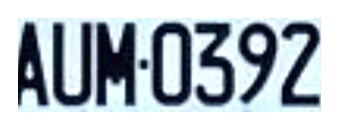

None


<ipython-input-6-0d481e7e39e0>:96: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  points = np.int0(points)


辨識結果:
AUM0392


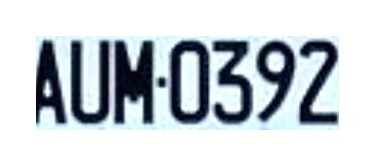

<ipython-input-6-0d481e7e39e0>:96: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  points = np.int0(points)


辨識結果:
AXE3880


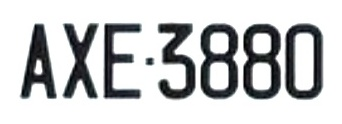

<ipython-input-6-0d481e7e39e0>:96: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  points = np.int0(points)


辨識結果:
AGR2214


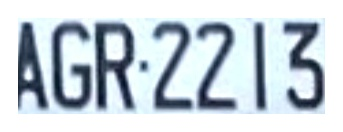

<ipython-input-6-0d481e7e39e0>:96: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  points = np.int0(points)


辨識結果:
ASE8375


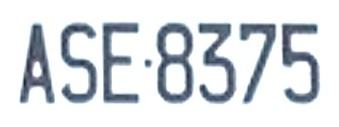

<ipython-input-6-0d481e7e39e0>:96: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  points = np.int0(points)


辨識結果:
AQJ2951


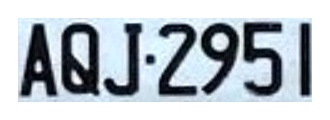

None


<ipython-input-6-0d481e7e39e0>:96: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  points = np.int0(points)


辨識結果:
AQJ295


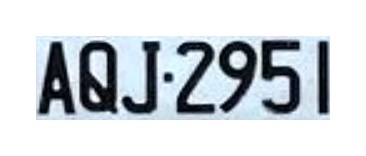

None


<ipython-input-6-0d481e7e39e0>:96: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  points = np.int0(points)


辨識結果:
AQJ2951


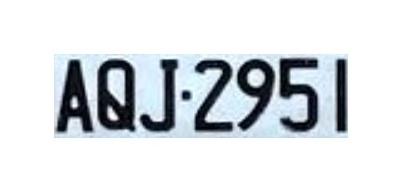

<ipython-input-6-0d481e7e39e0>:96: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  points = np.int0(points)


辨識結果:
AGP3659


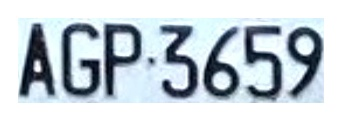

<ipython-input-6-0d481e7e39e0>:96: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  points = np.int0(points)


辨識結果:
HNT6302


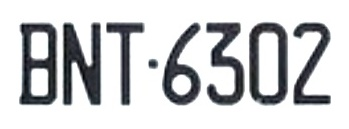

辨識結果:
72.10


<ipython-input-6-0d481e7e39e0>:96: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  points = np.int0(points)


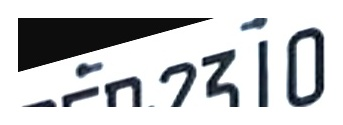

辨識結果:
AUM0392


<ipython-input-6-0d481e7e39e0>:96: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  points = np.int0(points)


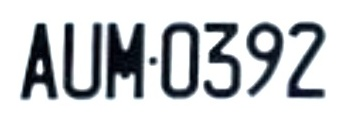

辨識結果:
ARQ3857


<ipython-input-6-0d481e7e39e0>:96: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  points = np.int0(points)


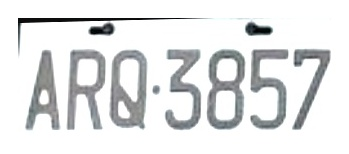

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import PIL
import glob
from PIL import Image
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import numpy as np
# !apt install tesseract-ocr
# !apt install libtesseract-dev
# !pip install pytesseract
# !pip install pillow
# import pytesseract
#照片路徑
files=glob.glob('/content/drive/MyDrive/3/*.JPG')
def photo_resize(img,target_width,target_height):
  # 調整圖片大小
  re_img=cv2.resize(img, (target_width, target_height))
  return re_img
#調整亮度與對比度
def adjusted(img,x,y):
  alpha = x
  beta = y

  adjusted_image = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

  return adjusted_image

def Sobel(img):
  Sobelx=cv2.Sobel(img,cv2.CV_32F,1,0)
  Sobelx=cv2.convertScaleAbs(Sobelx)
  return Sobelx

def Gussian(img):
  kernel_size = (5, 5)  # 高斯和大小 通常奇數
  sigma_x = 0  # X方向上的標準差，0 表示根據核大小自動計算
  # 高斯濾波器
  blurred_img = cv2.GaussianBlur(img, kernel_size, sigma_x)
  return blurred_img
def threshold(img):
  thr, binary = cv2.threshold(img,127, 255, cv2.THRESH_BINARY)
  return binary
def contours(img):
  contours1 = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #尋找輪廓
  contours = contours1[0]   #取得輪廓
  # cv2.drawContours(img, contours, -1, (0, 255, 0), 2)
  letters=[]
  for contour in contours:
    x,y,w,h=cv2.boundingRect(contour)
    if 15<h<85: #要改的參數!!!10<h<100
      letters.append(contour)
  # cv2.drawContours(contours_img, letters, -1, (255, 0, 0), 2)
  # cv2_imshow(contours_img)
  #找出最小x跟最大x
  min_x =float('inf')#正無窮
  max_x =0
  for letter in letters:
    for point in letter:
      x=point[0][0]
      min_x=min(min_x,x)
      max_x=max(max_x,x)
  return min_x,max_x
#image[y:h,x:w]
def cropped(img,x,y,h,w):
  cropped_img=img[y:h,x:w]

  return cropped_img

def erope(img):
  kernel=np.ones((3, 3),np.uint8)
  ero=cv2.erode(img,kernel,iterations=1)
  return ero

def dilate(img):
  kernel=np.ones((2, 5),np.uint8)
  dilation=cv2.dilate(img,kernel,iterations=8)
  return dilation

def findcontour(img):
  contours1 = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #尋找輪廓
  contours = contours1[0]   #取得輪廓
  points=None
  min_contour_length = 2500

  # 遍歷所有輪廓
  for contour in contours:
      # 計算輪廓的面積
      area = cv2.contourArea(contour)

      # 如果輪廓的面積大於2500，繪製最小外接矩形
      if area >= min_contour_length:
          # 計算輪廓的最小外接矩形
          rect = cv2.minAreaRect(contour)
          angle=rect[2]
          points = cv2.boxPoints(rect)
          points = np.int0(points)
          break

  if points is not None:
    if angle>=0:
      sorted_points = sorted(points, key=lambda x: x[0])
      bottom_left=sorted_points[0]
      top_left=sorted_points[1]
      bottom_right=sorted_points[2]
      top_right=sorted_points[3]

      return bottom_left,top_left,bottom_right,top_right
    else:
      sorted_points = sorted(points, key=lambda x: x[0])
      top_left=sorted_points[0]
      bottom_left=sorted_points[1]
      top_right=sorted_points[2]
      bottom_right=sorted_points[3]

      return bottom_left,top_left,bottom_right,top_right
  else:
    return 0,0,0,0

def affine(img,bottom_left,top_left,bottom_right,top_right):
  p1 = np.float32([(top_left),(top_right),(bottom_right)])
  p2 = np.float32([[top_left[0],top_right[1]],(top_right),(bottom_right)])
  M = cv2.getAffineTransform(p1, p2)

  h,w=adj_img.shape[:2]

  output = cv2.warpAffine(adj_img, M,(w,h))

  x=0
  y=min(top_right[1],bottom_right[1])
  h=abs(bottom_right[1]-top_right[1])

  output=output[y-5:y+h,x:x+w]
  # output=adjusted(output,-1.5,15)
  # output=adjusted(output,-1.3,12)
  # output=adjusted(output,-1.5,15)
  output=adjusted(output,-1.2,13)
  if output is not None:
    # output = cv2.cvtColor(output,cv2.COLOR_BGR2GRAY)
    # thr, output = cv2.threshold(output,127, 255, cv2.THRESH_BINARY)
    cv2.imwrite('output.jpg',output)
  else:
    print('None')
    pass

def bg(img):
  image=cv2.imread(img)
  height,width=image.shape[:2]
  new_height=height+36
  new_width=width+36
  x_offset=18
  y_offset=18
  #創建一個白色背景圖像
  background = np.ones((new_height, new_width, 3), dtype=np.uint8) * 255
  background[y_offset:y_offset+height,x_offset:x_offset+width]=image
  cv2.imwrite('output.jpg',background)

def tesseracttt(img):

  config = r'-c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789. --oem 3 --psm 6'
  text = pytesseract.image_to_string(img,lang='eng',config=config)

  if len(text) ==1:
    print('辨識失敗')
  else:
    clean_text = text.strip()#去除兩端不可見字符
    print('辨識結果:\n{}'.format(clean_text))
    img=cv2.imread(img)
    # cv2.putText(img, clean_text, (int(110), int(70)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)
    cv2_imshow(img)
    return text
for file in files:
  img=cv2.imread(file)
  #調整圖片大小
  # img=photo_resize(img,300,136)
  img=photo_resize(img,320,136)
  #調整圖片亮度與對比度
  adj_img=adjusted(img,-1.5,15)
  #灰階
  gray_img = cv2.cvtColor(adj_img,cv2.COLOR_BGR2GRAY)
  #索伯
  Sobelx=Sobel(gray_img)
  #高斯模糊
  blur_img=Gussian(Sobelx)
  #二值化
  binary=threshold(blur_img)
  # cv2_imshow(binary)
  # plt.imshow(cv2.cvtColor(binary, cv2.COLOR_BGR2RGB))
  # plt.axis('off')
  # plt.show()
  #找出輪廓
  min_x,max_x=contours(binary)
  #車牌框裁切
  cropped_img=cropped(binary,min_x,0,binary.shape[0],max_x)
  #侵蝕
  ero_img=erope(cropped_img)
  #膨脹
  dilate_img=dilate(ero_img)
  # cv2_imshow(dilate_img)
  #找出最小四邊形輪廓
  bottom_left,top_left,bottom_right,top_right=findcontour(dilate_img)
  # out_img=tesseract(output)

  adj_img=cropped(adj_img,min_x,0,img.shape[0],max_x)
  # cv2_imshow(adj_img)
  #訪設變換
  affine(adj_img,bottom_left,top_left,bottom_right,top_right)
  # cv2.imwrite('output.jpg',output)
  #字元辨識
  bg('output.jpg')
  text=tesseracttt('output.jpg')
  # print(text)


In [ ]:
print(text)

ARE7281



In [ ]:
#下載mysql connector
!pip install mysql-connector-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 50.5 MB/s eta 0:00:00


In [ ]:
#import相關套件
import mysql.connector
import pandas.io.sql as sql
import pandas as pd

In [ ]:
#連結到資料庫
config = {
    'user':'113403',
    'password':'@All3403@',
    'host':'140.131.114.242',
    'database':'113-law'
}
cnx=mysql.connector.connect(**config)
cursor = cnx.cursor()

In [ ]:
#新增資料
# text='AAA1234'
data = {'license_plate': [text],
        'date_time': ['2024-05-15 10:10:00'],
        'location': ['Taipei'],
        'violation': [False]}
df = pd.DataFrame(data)

In [ ]:
# SQL插入語句
add_violation = ("INSERT INTO testapp_car "
                 "(license_plate, date_time, location, violation) "
                 "VALUES (%s, %s, %s, %s)")

# 將DataFrame中的每一行數據插入數據庫中
for index, row in df.iterrows():
    data_violation = (row['license_plate'], row['date_time'], row['location'], row['violation'])
    cursor.execute(add_violation, data_violation)

# 提交
cnx.commit()

In [ ]:
# 關閉滑鼠與連結
cursor.close()
cnx.close()

In [ ]:
print(text)

ARE7281

